<a href="https://colab.research.google.com/github/Sumedh-1203/OE5450/blob/main/PINN_Laplace1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Define the PDE residual for the Laplace equation
def pde_residual(model, x, y):
    T = model(torch.cat([x, y], dim=1))
    T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T_y), create_graph=True)[0]
    residual = T_xx + T_yy
    return residual

In [ ]:
# Define the boundary condition loss
def boundary_loss(model, xb, yb, T_boundary):
    T_pred = model(torch.cat([xb, yb], dim=1))
    loss = nn.MSELoss()(T_pred, T_boundary)
    return loss

In [ ]:
# Generate training data
def generate_boundary_data(n):
    # Top boundary (y = 1)
    x_top = torch.linspace(0, 1, n).reshape(-1, 1)
    y_top = torch.ones_like(x_top)
    T_top = torch.full_like(x_top, 10.0)

    # Bottom boundary (y = 0)
    x_bottom = torch.linspace(0, 1, n).reshape(-1, 1)
    y_bottom = torch.zeros_like(x_bottom)
    T_bottom = torch.full_like(x_bottom, 0.0)

    # Left boundary (x = 0)
    y_left = torch.linspace(0, 1, n).reshape(-1, 1)
    x_left = torch.zeros_like(y_left)
    T_left = torch.full_like(y_left, 10.0)

    # Right boundary (x = 1)
    y_right = torch.linspace(0, 1, n).reshape(-1, 1)
    x_right = torch.ones_like(y_right)
    T_right = torch.full_like(y_right, 5.0)

    # Combine all boundary points
    xb = torch.cat([x_top, x_bottom, x_left, x_right], dim=0)
    yb = torch.cat([y_top, y_bottom, y_left, y_right], dim=0)
    T_boundary = torch.cat([T_top, T_bottom, T_left, T_right], dim=0)

    return xb, yb, T_boundary

Iteration 0: Loss = 5897.63232421875
Iteration 100: Loss = 2392.80126953125
Iteration 200: Loss = 1770.0714111328125
Iteration 300: Loss = 1234.89208984375
Iteration 400: Loss = 758.1990356445312
Iteration 500: Loss = 571.9692993164062
Iteration 600: Loss = 477.3045959472656
Iteration 700: Loss = 400.997314453125
Iteration 800: Loss = 324.1998291015625
Iteration 900: Loss = 276.016845703125
Iteration 1000: Loss = 252.7504119873047
Iteration 1100: Loss = 237.41653442382812
Iteration 1200: Loss = 225.2945556640625
Iteration 1300: Loss = 214.61058044433594
Iteration 1400: Loss = 206.98123168945312
Iteration 1500: Loss = 199.31227111816406
Iteration 1600: Loss = 192.9822998046875
Iteration 1700: Loss = 188.88116455078125
Iteration 1800: Loss = 181.56300354003906
Iteration 1900: Loss = 177.71627807617188
Iteration 2000: Loss = 172.1094512939453
Iteration 2100: Loss = 169.85690307617188
Iteration 2200: Loss = 165.9224853515625
Iteration 2300: Loss = 162.52740478515625
Iteration 2400: Loss = 

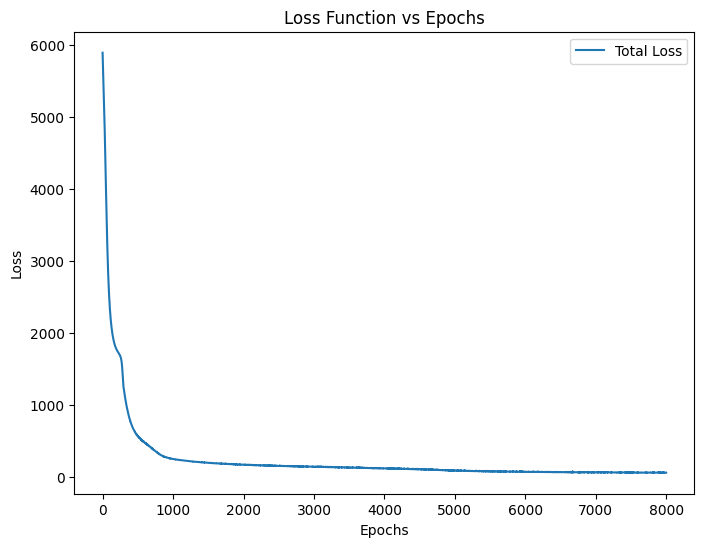

In [ ]:
# Training the PINN and tracking loss
def train_pinn(model, optimizer, n_iterations, n_boundary, n_domain, boundary_weight):
    losses = []  # To store loss values for plotting
    for iteration in range(n_iterations):
        optimizer.zero_grad()

        # Boundary loss
        xb, yb, T_boundary = generate_boundary_data(n_boundary)
        loss_boundary = boundary_loss(model, xb, yb, T_boundary)

        # Domain loss (PDE residual)
        x_domain = torch.rand(n_domain, 1).requires_grad_(True)
        y_domain = torch.rand(n_domain, 1).requires_grad_(True)
        residual = pde_residual(model, x_domain, y_domain)
        loss_domain = torch.mean(residual ** 2)

        # Total loss
        loss = boundary_weight * loss_boundary + loss_domain
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Store the loss value

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item()}")

    return losses

# Plotting the loss function vs epochs
def plot_loss(losses):
    if not losses:
        print("No loss data to plot.")
        return

    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function vs Epochs')
    plt.legend()
    plt.show()

# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model and plot the loss function
n_iterations = 8000
n_boundary = 100
n_domain = 10000
boundary_weight = 100.0  # Increase this weight to enforce boundary conditions more strictly
losses = train_pinn(model, optimizer, n_iterations, n_boundary, n_domain, boundary_weight)
plot_loss(losses)

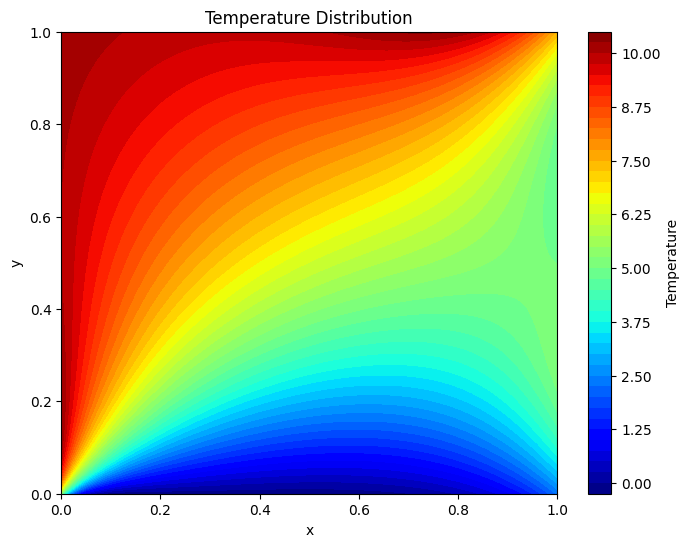

In [ ]:
# Function to visualize the results
def visualize_results(model, resolution=100):
    # Create a grid of points over the domain
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)

    # Predict the temperature at each point
    with torch.no_grad():
        T_pred = model(points).numpy().reshape(resolution, resolution)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, T_pred, 50, cmap='jet')
    plt.colorbar(label='Temperature')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature Distribution')
    plt.show()

# Visualize the results
visualize_results(model)

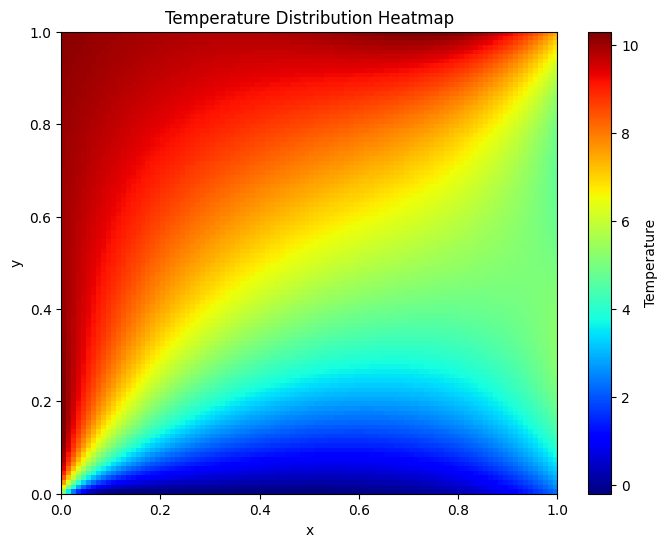

In [ ]:
# Function to visualize the results as a heatmap
def visualize_heatmap(model, resolution=100):
    # Create a grid of points over the domain
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)

    # Predict the temperature at each point
    with torch.no_grad():
        T_pred = model(points).numpy().reshape(resolution, resolution)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(T_pred, extent=(0, 1, 0, 1), origin='lower', cmap='jet', aspect='auto')
    plt.colorbar(label='Temperature')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature Distribution Heatmap')
    plt.show()

# Visualize the results as a heatmap
visualize_heatmap(model)